In [ ]:
!pip install nilearn

In [48]:
from nilearn import datasets, image
from nilearn.input_data import NiftiLabelsMasker
yeo = datasets.fetch_atlas_yeo_2011()

[get_dataset_dir] Dataset found in /root/nilearn_data/yeo_2011

In [49]:
!wget https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE_Initiative/Resources/cc200_roi_atlas.nii.gz

--2025-04-15 14:27:14--  https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE_Initiative/Resources/cc200_roi_atlas.nii.gz
Resolving fcp-indi.s3.amazonaws.com (fcp-indi.s3.amazonaws.com)... 3.5.29.213, 54.231.236.161, 54.231.137.57, ...
Connecting to fcp-indi.s3.amazonaws.com (fcp-indi.s3.amazonaws.com)|3.5.29.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12338 (12K) [application/octet-stream]
Saving to: ‘cc200_roi_atlas.nii.gz.2’

cc200_roi_atlas.nii 100%[===================>]  12.05K  --.-KB/s    in 0s      

2025-04-15 14:27:14 (150 MB/s) - ‘cc200_roi_atlas.nii.gz.2’ saved [12338/12338]



In [50]:
import nibabel as nib
cc200_img = nib.load("/kaggle/working/cc200_roi_atlas.nii.gz")
yeo_img = nib.load(yeo.thick_7)

In [51]:
yeo_data = yeo_img.get_fdata()
cc200_data = cc200_img.get_fdata()

In [52]:
yeo_data.shape

(256, 256, 256, 1)

In [53]:
from nilearn.image import resample_to_img
cc200_resampled = resample_to_img(cc200_img, yeo_img, interpolation='nearest')
cc200_resampled.to_filename("CC200_resampled_to_Yeo7.nii.gz")
cc200_resampled_data = cc200_resampled.get_fdata()

/tmp/ipykernel_31/2186592119.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  cc200_resampled = resample_to_img(cc200_img, yeo_img, interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [54]:
import numpy as np
yeo_data = np.squeeze(yeo_data) 
yeo_img = nib.Nifti1Image(yeo_data, yeo_img.affine)
print(f"CC200 resampled shape: {cc200_resampled.shape}")
print(f"Yeo7 shape: {yeo_img.shape}")
assert cc200_resampled.shape == yeo_img.shape, "Atlases do not have the same shape after resampling!"
assert np.allclose(cc200_resampled.affine, yeo_img.affine), "Atlases are not aligned after resampling!"

CC200 resampled shape: (256, 256, 256)
Yeo7 shape: (256, 256, 256)


In [56]:
from collections import Counter

cc200_to_yeo7_mapping = {}

for region_id in range(1, 201): 
    region_mask = cc200_resampled_data == region_id
    
    yeo_labels = yeo_data[region_mask]
    
    yeo_labels = yeo_labels[yeo_labels > 0] 
    if len(yeo_labels) > 0:
        most_common_label = Counter(yeo_labels.astype(int)).most_common(1)[0][0]
        cc200_to_yeo7_mapping[region_id] = most_common_label
    else:
        cc200_to_yeo7_mapping[region_id] = 0

In [57]:
import csv

with open("cc200_to_yeo7_mapping.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["CC200_Region", "Yeo7_Network"])
    for region_id, network_id in cc200_to_yeo7_mapping.items():
        writer.writerow([region_id, network_id])

In [ ]:
unique_values, counts = np.unique(cc200_resampled_data, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

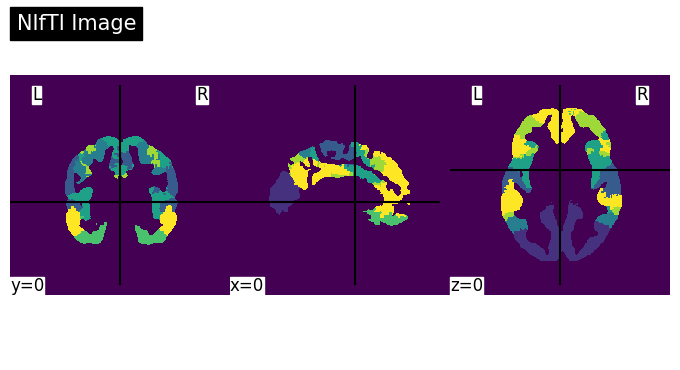

In [39]:
from nilearn import plotting
plotting.plot_img(yeo_img, title="NIfTI Image", display_mode='ortho', draw_cross=True, cut_coords=(0, 0, 0))
plotting.show()

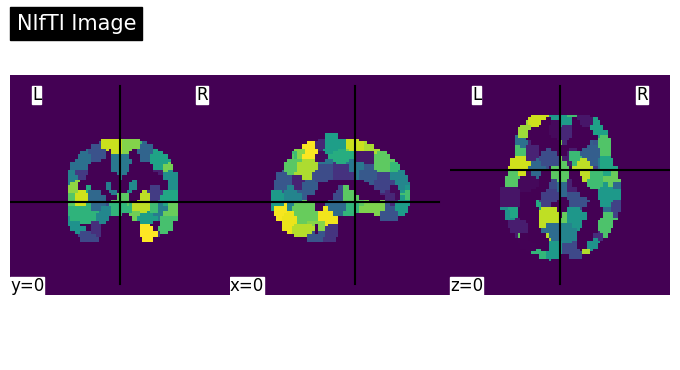

In [40]:
from nilearn import plotting
plotting.plot_img(cc200_resampled, title="NIfTI Image", display_mode='ortho', draw_cross=True, cut_coords=(0, 0, 0))
plotting.show()

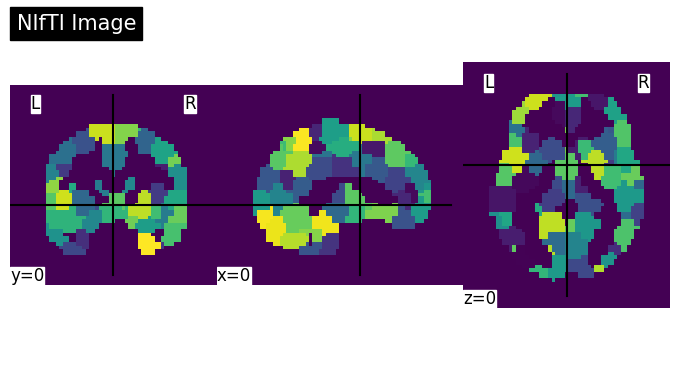

In [41]:
from nilearn import plotting
plotting.plot_img(cc200_img, title="NIfTI Image", display_mode='ortho', draw_cross=True, cut_coords=(0, 0, 0))
plotting.show()

In [59]:
a  = np.loadtxt("/kaggle/input/autistic-brains/Outputs/cpac/nofilt_noglobal/rois_cc200/CMU_a_0050649_rois_cc200.1D")
a.shape

(236, 200)

In [ ]:
region_indices = {i: [] for i in range(1, 8)}
for i, j in cc200_to_yeo7_mapping.items():
    if j == 0:
        continue
    region_indices[j].append(i - 1)
region_indices

In [74]:
correlation_matrices = []
for i in region_indices.keys():
    m = a[:, region_indices[i]]
    correlation_matrix = np.corrcoef(m, rowvar=False)
    correlation_matrices.append(correlation_matrix)
    print(correlation_matrix.shape)

(43, 43)
(22, 22)
(21, 21)
(22, 22)
(15, 15)
(21, 21)
(41, 41)


In [75]:
def flatten_matrix(matrix):
    idx = np.triu_indices_from(matrix, k=1)
    return matrix[idx]

In [76]:
import torch
import torch.nn as nn

class SubnetworkEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.mlp(x)

In [77]:
flattened = [flatten_matrix(m) for m in correlation_matrices]

tensors = [torch.tensor(f, dtype=torch.float32) for f in flattened]

mlps = [SubnetworkEmbedder(len(f)) for f in flattened]
embedded = [mlp(f) for mlp, f in zip(mlps, tensors)]

O_sub = torch.stack(embedded)
O_sub.shape

torch.Size([7, 128])